## Lensing correction terms on galaxy-galaxy auto correlation (incl between different redshift bins)

#### This notebook evaluates the terms in Section 6 of the paper.
##### Computation of some Cls has been shifted to parallelized python scripts. Instructions for running them are given below.

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
sys.path.append("../scripts/") 
from lab import *
%matplotlib inline

### Step 1:
#### run the next two cells to create settings file (before running the Cl scripts)

In [129]:
# choose settings
##### settings ########
LSST      = False
#if not LSST redhsift kernel
z0_1      = 2.9
sigma_z_1 = 0.2
z0_2      = 3.5
sigma_z_2 = 0.1
bin_num1 = 'all'
bin_num2 = 'all'
# choose zmax as high as needed and as low as possible
zmax  = 4
bias  = 'simple'
chimax = chi_z(zmax)
print('zmax=%d'%zmax, 'chimax=%d'%chimax)
#########################

zmax=4 chimax=4970


In [130]:
if LSST:
    file_ext = 'lsst_%s_%s'%(str(bin_num1), str(bin_num2))
else:
    file_ext = 'gaussgal_z0%d_%d_sigmaz%d_%d'%(z0_1*10,z0_2*10,sigma_z_1*10,sigma_z_2*10)
    
file_ext+=bias+'_bias'

file_ext+=  'zmax%d'%(zmax*10)
file_ext2 = 'zmax%d'%(zmax*10)
    
print(file_ext, file_ext2)


params = {}
params['LSST']    = LSST
params['z01']     = z0_1
params['sigma_z1']= sigma_z_1
params['z02']     = z0_2
params['sigma_z2']= sigma_z_2
params['bin_num1']= bin_num1
params['bin_num2']= bin_num2
params['chimax']  = chimax
params['bias']    = bias
params['ext']     = file_ext
params['ext2']    = file_ext2

if bias == 'simple':
    bias_func = simple_bias
elif bias =='constant':
    bias_func = constant_bias
else:
    print('no valid bias function selected')

print(params['bin_num2'])
try:
    pickle.load(open('../settings/params_auto_%s.pkl'%file_ext,'rb'))
except:
    pickle.dump(params,open('../settings/params_auto_%s.pkl'%file_ext,'wb'))

gaussgal_z029_35_sigmaz2_1simple_biaszmax40 zmax40
all


### Step 2: 
#### - now copy/paste the filename into run_all_scripts_auto.sh
#### - allocate at min 100 processes and run the script
#### - then continue with this notebook

In [131]:
plotpath = '../plots/clgg_%s/'%file_ext
if os.path.isdir(plotpath):
    print('plot path exists')
else:
    os.mkdir(plotpath)

In [132]:
if LSST:
    kernel1 = gal_clus(dNdz_LSST, b=bias_func, bin_num=bin_num1)
    kernel2 = gal_clus(dNdz_LSST, b=bias_func, bin_num=bin_num2)
else:
    kernel1 = gal_clus(Gauss_redshift(sigma_z=sigma_z_1,z0=z0_1), bias_func)
    kernel2 = gal_clus(Gauss_redshift(sigma_z=sigma_z_2,z0=z0_2), bias_func)

In [133]:
L = np.logspace(np.log10(min(ell_)),np.log10(1000),100)
l = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),500)
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)

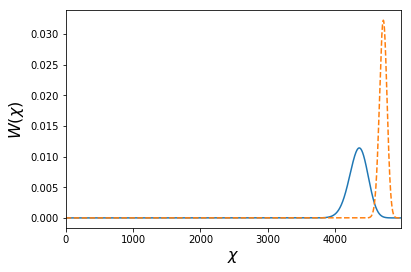

In [134]:
chis = np.linspace(1,chimax,20000)
plt.figure()
plt.plot(chis,kernel1(chis), label='kernel 1')
plt.plot(chis,kernel2(chis), label='kernel 2',ls='--')
plt.xlabel('$\chi$',fontsize=16)
plt.ylabel('$W(\chi)$',fontsize=16)
plt.xlim(0,chimax)
plt.savefig(plotpath+'redshiftkernels_%s.pdf'%file_ext, bbox_inches='tight')

In [8]:
### for harmonic space integrals
L   = np.logspace(np.log10(min(ell_)),np.log10(1000),100)
l   = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),500)
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)

In [9]:
# auto spectrum
#clgg
try:
    ell_,Cl_gg= np.load('../output/cls/Clgg_%s.npy'%(file_ext))
except:
    begin=time.time()
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    n = 4
    chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax))
    chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

    chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
    chi2fac01 = (kernel2(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax))
    chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = w11*w12*chi1fac0* chi2fac0

    result=np.zeros_like(ell_)
    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I4_ltrc[ii])

    Cl_gg = chimax * result/np.pi**2/2./4. #dividing by extra factor of 4 (should be there because of Gaussian Quadrature)

    np.save('../output/cls/Clgg_%s.npy'%(file_ext),[ell_,Cl_gg])

    print('Time taken = ', time.time()-begin)

#### Cl22A

In [10]:
# these files only depend on zmax, hence file_ext2 extension
# script: clphiphi_VB_parallel_split.py
chi1s, chi2s, clphiphirt         = np.load('../G_matrices/clphiphi_rt_%s.npy'%file_ext2)
# script: # script: clphiphi_VB_parallel_split2.py
chi1s_, chi2s_, clphiphir_over_t = np.load('../G_matrices/clphiphi_r_over_t_%s.npy'%file_ext2)
clphiphirt                       = np.swapaxes(clphiphirt,1,2)
clphiphir_over_t                 = np.swapaxes(clphiphir_over_t,1,2)

In [11]:
# this is cldeltadelta weighted by clphiphi, as it appears in the (2,2)-term
try: 
    _, Mgg22A = np.load('../M_matrices/Mgg22A_%s.npy'%file_ext)
    Mgg22A_spline = RectBivariateSpline(ell_,ell_,Mgg22A)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    clphiphirt_       = np.expand_dims(clphiphirt,-1)
    clphiphir_over_t_ = np.expand_dims(clphiphir_over_t,-1)

    result = np.zeros((len(ell_),len(ell_)))

    n = 4

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*clphiphirt_[nn])
        chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*clphiphir_over_t_[nn])
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax      = ell_.size
        # phiphi should be second entry, associated with l (this is after variable trafo needed for evaluation)
        for ii  in range(ell_.size):        
            result[ii][nn] = np.sum(chifacs*I4_ltrc[ii])

    print(time.time()-begin)

    Mgg22A = chimax*result*1./np.pi**2/2./4.
    np.save('../M_matrices/Mgg22A_%s.npy'%str(file_ext),[np.meshgrid(ell_),Mgg22A])

    Mgg22A_spline = RectBivariateSpline(ell_,ell_,Mgg22A)

#### Cl31

In [12]:
# script: clphiphi_VB_parallel.py
clphiphi   = np.load('../G_matrices/clphiphi_parallel_%s.npy'%file_ext2)

cl_phiphi_diag= np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    cl_phiphi_diag[:,ii]=clphiphi[:,ii,ii]

clphiphi_diag=[]
from scipy.interpolate import interp1d
for ii in range(len(ell_)):
    clphiphi_diag+=[interp1d(chimax*t_,cl_phiphi_diag[ii])]

In [13]:
# this is cldeltadelta weighted by clphiphi(chi), as it appears in the (1,3a)-term
try:
    _, Mgg31a = np.load('../M_matrices/Mgg31a_%s.npy'%file_ext)
    _, Mgg31aA = np.load('../M_matrices/Mgg31aA_%s.npy'%file_ext)
    _, Mgg31aB = np.load('../M_matrices/Mgg31aB_%s.npy'%file_ext)
    Mgg31a_spline = RectBivariateSpline(ell_,ell_,Mgg31a)
    Mgg31aA_spline = RectBivariateSpline(ell_,ell_,Mgg31aA)
    Mgg31aB_spline = RectBivariateSpline(ell_,ell_,Mgg31aB)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    n = 4

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
        chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):   
            # phiphi should be second entry associated with l
            result[ii][nn] = np.sum(chifacs*I4_ltrc[ii])

    Mgg31aA = chimax * result*1./np.pi**2/2./4.
    
    #and same again with exchanged kernels
    result = np.zeros((len(ell_),len(ell_)))  
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (kernel2(r2d*chimax)*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (kernel1(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
        chi2fac01 = (kernel1(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):   
            # phiphi should be second entry associated with l
            result[ii][nn] = np.sum(chifacs*I4_ltrc[ii])

        

        Mgg31aB = chimax * result*1./np.pi**2/2./4.
        
    print(time.time()-begin)
    
    Mgg31a= (Mgg31aA+Mgg31aB)*-0.5 #inlcude factor of -0.5 here to comply with chirag's convention

    np.save('./M_matrices/Mgg31a_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg31a])
    np.save('./M_matrices/Mgg31aA_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg31aA])
    np.save('./M_matrices/Mgg31aB_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg31aB])

    Mgg31a_spline = RectBivariateSpline(ell_,ell_,Mgg31a)
    Mgg31aA_spline = RectBivariateSpline(ell_,ell_,Mgg31aA)
    Mgg31aB_spline = RectBivariateSpline(ell_,ell_,Mgg31aB)

In [14]:
def get_regularized_sum_of_terms_1(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


def get_regularized_sum_of_terms_2(L,L1,phi,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*((LL*LL1*nu-LL1*LL1)**2+(LL*LL1*nu)**2)*(M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

def get_Limber22_term(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M(L_,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

def get_Limber13_term(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*(LL*LL1*nu)**2*M(LL,LL1,grid=False)
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2*0.5*(-1)
    return res

In [15]:
#factor 0.5 from taylor expansion, also added in the draft and consistent with 2.13 in 21cm lensing paper
try: 
    assert(False)
    L, LimberTerms,LimberTerm13,LimberTerm22=np.load('../output/results/auto_LimberTerms_%s.npy'%file_ext)
except:
    LimberTerms  = get_regularized_sum_of_terms_1(L,l,phi,Mgg22A_spline,Mgg31a_spline,method='trapz')+get_regularized_sum_of_terms_2(L,l,phi,Mgg31a_spline,method='trapz')
    LimberTerm13 = get_Limber13_term(L,l,phi,Mgg31a_spline,method='trapz')
    LimberTerm22 = get_Limber22_term(L,l,phi,Mgg22A_spline,method='trapz')
    np.save('../output/results/auto_LimberTerms_%s.npy'%file_ext,[L, LimberTerms,LimberTerm13,LimberTerm22])

#### Cl22B

In [16]:
# get cldeltaphi for second <22> term
# same as old code
try:
    clphidelta = np.load('../G_matrices/clphidelta_%s.npy'%file_ext2)
except:
    
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi) * (xmax > xi)

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    chimax2  = chimax

    n = 2

    Cl = np.zeros((len(t_),len(ell_),len(t_)))

    begin=time.time()

    for jj, chimax1 in enumerate((t_*chimax)):
        if jj%10==0:
            print(jj)

        chi1fac0  = D_chi(r2d*chimax2)
        chi1fac0  = chi1fac0 *(r2d*chimax2)**(1-(n+nu_n_).reshape(1, 1, -1))
        chi2fac00 = (D_chi(r2d*t2d*chimax2)*(1+z_chi(r2d*t2d*chimax2))*inner_kernel(r2d*t2d*chimax2, chimax1))
        chi2fac01 = (inner_kernel(1./t2d*r2d*chimax2,chimax1)*D_chi(r2d*1./t2d*chimax2)*(1+z_chi(r2d*1./t2d*chimax2)))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01
        
        chifacs   = w12*chi1fac0* chi2fac0

        result    = np.zeros((len(ell_),len(t_)))
        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[ii] = np.sum(chifacs*I2_ltrc[ii],axis=(0,2))

        Cl[jj] = result*1./np.pi**2/2.*prefac/2.*-2 #no chimax because not summing over r, -2 for psi-> phi

    clphidelta = np.swapaxes(Cl,0,1)
    print('Time taken = ', time.time()-begin)


    # first axis ell, delta goes as r2d
    np.save('../G_matrices/clphidelta_%s'%file_ext2,clphidelta)
    
# phi goes as r2d
cldeltaphi = np.swapaxes(clphidelta,1,2)

In [17]:
# this is the second term in <2,2>
try:
    _ , Mgg22B = np.load('../M_matrices/Mgg22B_%s.npy'%file_ext)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            # first index is |L-l|, clphidelta-> delta goes as r2d, goes with kernel2 -> goes with L-l
            result[ii][jj] = np.sum(w11*w12*kernel1(t2d*chimax)*kernel2(r2d*chimax)*cldeltaphi[jj]*clphidelta[ii])
    result*=chimax**2/4.

    Mgg22B = result

    # first index is L
    np.save('../M_matrices/Mgg22B_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg22B])

Mgg22B_spline = RectBivariateSpline(ell_,ell_,Mgg22B)

#### Cl31

In [18]:
#integral over last CL
clpsigal1, chis     = np.load('../G_matrices/clpsigal_kernel1%s.npy'%file_ext)
clpsigal2, chis     = np.load('../G_matrices/clpsigal_kernel2%s.npy'%file_ext)
#first entry is phi
clphidelta_M31, chimaxs = np.load('../G_matrices/clphidelta_parallel_M31b_auto_%s.npy'%file_ext)

In [19]:
# this is the first term in <3, 1 b>
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi)*(xmax > xi)

try:
    _ , Mgg31b = np.load('../M_matrices/Mgg31b_%s.npy'%file_ext)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            # first index is L
            result[ii][jj] = np.sum(w11*w12*r2d*lensing_kernel(t2d*r2d*chimax,r2d*chimax)*kernel1(r2d*chimax)*clphidelta_M31[jj]*clpsigal2[ii])
    result*=chimax**2/4.*2 #the last times two comes from the actual expression

    Mgg31b = result

    # first index is L
    np.save('../M_matrices/Mgg31b_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg31b])

Mgg31b_spline = RectBivariateSpline(ell_,ell_,Mgg31b)

In [20]:
# this is the first term in <1, 3 b>
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi)*(xmax > xi)

try:
    _ , Mgg13b = np.load('../M_matrices/Mgg13b_%s.npy'%file_ext)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            # first index is L
            result[ii][jj] = np.sum(w11*w12*r2d*lensing_kernel(t2d*r2d*chimax,r2d*chimax)*kernel2(r2d*chimax)*clphidelta_M31[jj]*clpsigal1[ii])
    result*=chimax**2/4.*2 #the last times two comes from the actual expression

    Mgg13b = result

    # first index is L
    np.save('./M_matrices/Mgg13b_%s.npy'%file_ext,[np.meshgrid(ell_),Mgg13b])

Mgg13b_spline = RectBivariateSpline(ell_,ell_,Mgg13b)

In [21]:
Mgg13b_spline_sym = RectBivariateSpline(ell_,ell_,Mgg13b+Mgg31b)

In [22]:
def get_regularized_sum_of_terms_11(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


def get_regularized_sum_of_terms_22(L,L1,phi,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*((LL*LL1*nu)**2+(LL*LL1*nu-LL1*LL1)**2)*(M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


def get_noLimber22_term(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M(L_,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

#gives same result, because of symmetry
def get_noLimber22_term2(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = LL1*(LL*LL1*nu-LL1*LL1)**2*(M(LL1,L_,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

def get_noLimber13_term(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*(LL*LL1*nu)**2*(M(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

In [23]:
try:
    assert(False)
    L, NoLimberTerms,NoLimberTerm1,NoLimberTerm2=np.load('../output/results/auto_LimberTerms_%s.npy'%file_ext)
except:
    NoLimberTerms = get_regularized_sum_of_terms_11(L,l,phi,Mgg22B_spline,Mgg13b_spline_sym,method='trapz')+get_regularized_sum_of_terms_22(L,l,phi,Mgg13b_spline_sym,method='trapz')
    NoLimberTerm1 = get_noLimber22_term(L,l,phi,Mgg22B_spline)
    NoLimberTerm2 = get_noLimber13_term(L,l,phi,Mgg13b_spline_sym)

    np.save('../output/results/auto_LimberTerms_%s.npy'%file_ext,[L, NoLimberTerms,NoLimberTerm1,NoLimberTerm2])

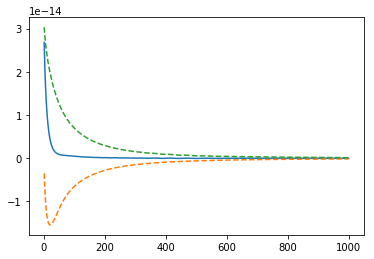

In [24]:
plt.plot(L,NoLimberTerms, ls ='-')
plt.plot(L,NoLimberTerm2, ls ='--')
plt.plot(L,NoLimberTerm1, ls ='--')

#### magnification bias terms

In [25]:
# same cldeltaphi as in 22 code, defined and computed above (without 5(s-0.4) prefactor)
try:
    _ , MgJbias = np.load('../M_matrices/MgJbias_%s.npy'%(file_ext))
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_)))
    for ii in range(len(ell_)):
        result[ii] = np.sum(w11*w12*(kernel1(t2d*chimax)*kernel2(r2d*chimax)*cldeltaphi[ii]+kernel2(t2d*chimax)*kernel1(r2d*chimax)*cldeltaphi[ii]))
    #check sign!!
    result*=chimax**2/4.*(0.5)*ell_**2
                           
    MgJbias = result

    # first index is L
    np.save('../M_matrices/MgJbias_%s.npy'%(file_ext),[np.meshgrid(ell_),MgJbias])

### J1-J1

In [26]:
# script: clphiphi_VB_parallel.py, (without [5(s-0.4)]**2 prefactor)
clphiphi   = np.load('../G_matrices/clphiphi_parallel_%s.npy'%file_ext2)

try:
    _ , MJJbias = np.load('../M_matrices/MJJbias_%s.npy'%(file_ext))
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_)))
    for ii in range(len(ell_)):
        result[ii] = np.sum(w11*w12*kernel1(t2d*chimax)*kernel2(r2d*chimax)*clphiphi[ii])
    #check sign!!
    result*=(chimax**2/4.*(0.5*ell_**2)**2)
                           
    MJJbias = result

    # first index is L
    np.save('../M_matrices/MJJbias_%s.npy'%(file_ext),[np.meshgrid(ell_),MJJbias])

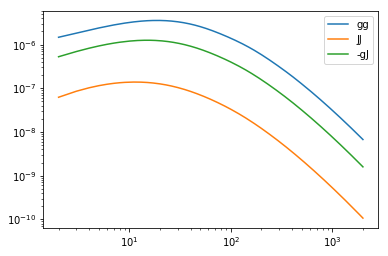

In [29]:
plt.figure()
plt.loglog(ell_, Cl_gg, label='gg')
plt.loglog(ell_, MJJbias, label='JJ')
plt.loglog(ell_, -MgJbias, label='-gJ')
plt.legend()